In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
# from dark import *
from Psemodel.psemodel import *
# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [3]:
arch = Darknet([1,2,2,2,2], 28, 32, 4)
# arch = wrn_22_10()

In [4]:
arch

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): PSEBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): PSEModule(
       

In [5]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [6]:
fname = train_names[0]

In [7]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 20 ms


In [8]:
im.shape

torch.Size([4, 512, 512])

In [9]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [10]:
from fastai.data_block import _extract_input_labels
fnames, labels = _extract_input_labels(seg, label_delim=' ')
test_fnames, _ = _extract_input_labels(sample_sub)

In [11]:
classes = uniqueify(np.concatenate(labels))

In [12]:
stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704,0.10145, 0.15313, 0.13814])
norm,denorm = normalize_funcs(*stats)

In [13]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.4, max_warp=0.4)

In [14]:
def get_data(sz=64, bs=64, is_test=False, pct = 0.1):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
    
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)



def get_data_custom(sz=64, bs=128, pct = 0.1):
        folder=TRAIN
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
        train_ds, val_ds = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
        
        datasets = [train_ds,val_ds, test_ds]
        datasets = transform_datasets(*datasets, tfms=tfms, size=sz)
        sampler = ImbalancedDatasetSampler(datasets[0])
        train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
        val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
        test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)
        
        return ImageDataBunch(train_dl, val_dl, test_dl, tfms=norm)


In [15]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [16]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [17]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1], loss_func=FocalLoss(gamma=5))
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 64

In [18]:
data = get_data_custom(64, 128, 0.1)
learn = get_learner(data, focal=True, fp16=False)

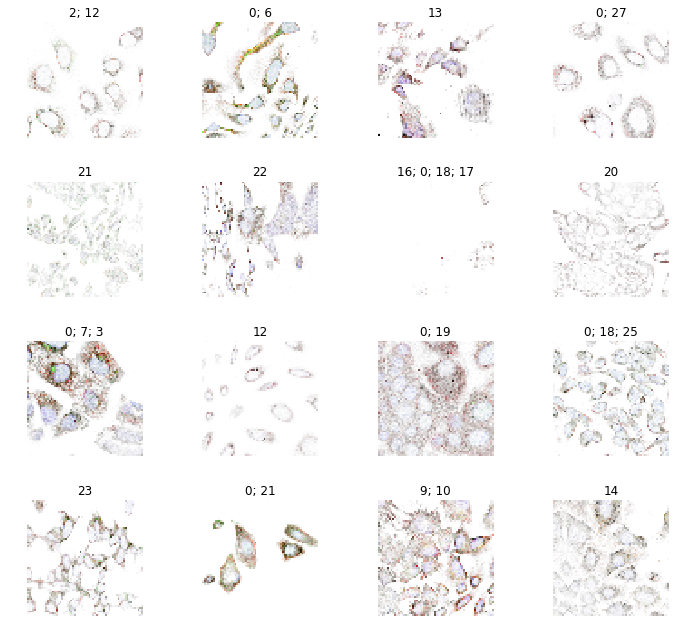

In [19]:
data.show_batch(rows=4, figsize=(10,9))

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


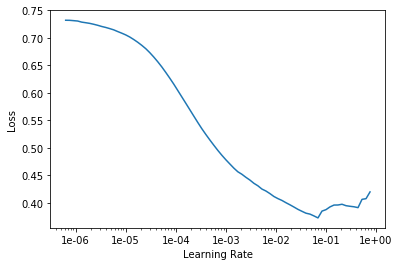

In [20]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr=1e-3

In [ ]:
%time learn.fit_one_cycle(30, lr, wd=0.3, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.177614,0.201089,0.944683,0.038648
2,0.170359,0.189249,0.944624,0.051346


# 128

In [ ]:
learn.data = get_data_custom(128, 48, 0.1)

In [ ]:
learn.split((arch.layers[9],arch.layers[15]))

In [ ]:
learn.freeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(lr), wd=0.2, div_factor=10, pct_start=0.5)

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(lr/10, lr), wd=0.2, div_factor=10, pct_start=0.5)

In [ ]:
learn.save('dk_pse_128')

# 256

In [ ]:
learn.data = get_data_custom(256, 12, 0.01)
# learn = get_learner(data, focal=True, fp16=True)

In [ ]:
learn.freeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(1e-4), wd=0.3, div_factor=10, pct_start=0.3)

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(1e-5, 1e-4), wd=0.3, div_factor=10, pct_start=0.3)

In [ ]:
learn.save('dk_pse_256')

In [ ]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# 512

In [ ]:
learn.data = get_data_custom(512, 4, 0.01)

In [ ]:
learn.freeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(1e-4), wd=0.3, div_factor=10, pct_start=0.3)

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(10, slice(1e-5, 1e-4), wd=0.3, div_factor=10, pct_start=0.3)

In [ ]:
learn.save('dk_pse_512');

# Validation and Preds

In [ ]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
#valid data
learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds()

In [85]:
# np.save("preds500", to_np(p))

In [44]:
p_v.shape

torch.Size([15601, 28])

In [45]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [46]:
p_v_s = p_v.sigmoid()

In [47]:
f1(p_v, t_v)

tensor(0.8031)

In [48]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [49]:
f1_np(p_v_np, t_v_np)

0.8031076110720621

In [50]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [51]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [52]:
x = np.linspace(0,1,100)

In [53]:
y = np.array([f1_n(p_v_np, t_v_np, th, 1) for th in x])

In [54]:
import matplotlib.pyplot as plt

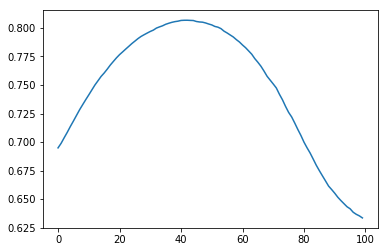

In [55]:
plt.plot(y)

In [56]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [44]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [57]:
f1_np(p_v_np, t_v_np, ths)

0.824124528146538

# Sub File

In [45]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [46]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [47]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [48]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2 3
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 5 25 6 19
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 18 25 21 6 19
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 7 18 25 23 26 27
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 23
